# Phase 2: RFM Analysis & Customer Scoring
## Intelligent Customer Segmentation & Revenue Optimization

**Objective**: Segment customers based on Recency, Frequency, and Monetary value to enable targeted marketing

**Deliverables**:
- Individual RFM scores (1-5 scale) for each customer
- RFM segments (Champions, Loyal, At Risk, Lost, etc.)
- Segment profiles with business metrics
- Executive dashboard visualizations
- Actionable marketing recommendations per segment

---

## 📚 What is RFM Analysis?

**RFM** is a proven customer segmentation technique that scores customers based on:

1. **Recency (R)**: How recently did the customer make a purchase?
   - *Business Logic*: Recent customers are more likely to respond to offers
   - *Score*: 5 = Most recent, 1 = Least recent

2. **Frequency (F)**: How often does the customer purchase?
   - *Business Logic*: Frequent buyers show loyalty and engagement
   - *Score*: 5 = Most frequent, 1 = Least frequent

3. **Monetary (M)**: How much does the customer spend?
   - *Business Logic*: High spenders are most valuable to the business
   - *Score*: 5 = Highest spenders, 1 = Lowest spenders

**Combined RFM Score**: Customers get a 3-digit score (e.g., "555" = Champions, "111" = Lost)

---

In [10]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


---
## 1️⃣ Load Cleaned Data from Phase 1

In [11]:
# Load the dataset
# If you ran Phase 1, use the cleaned data; otherwise use the original
path = "/home/cairo/code/portfolio/customer-segmentation/data/"
path_processed = "/home/cairo/code/portfolio/customer-segmentation/data/processed/"
path_reports = "/home/cairo/code/portfolio/customer-segmentation/outputs/reports/"
path_features = "/home/cairo/code/portfolio/customer-segmentation/data/features/"
path_campaigns = "/home/cairo/code/portfolio/customer-segmentation/outputs/campaigns/"
path_figures = "/home/cairo/code/portfolio/customer-segmentation/outputs/figures/"
path_models = "/home/cairo/code/portfolio/customer-segmentation/outputs/models/"


try:
    df = pd.read_csv(path_processed + 'data_cleaned.csv')
    print("✅ Loaded cleaned data from Phase 1")
except FileNotFoundError:
    print("⚠️  Cleaned data not found, loading and cleaning original dataset...")
    df = pd.read_csv(path + 'online_retail.csv')
    
    # Apply cleaning filters
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['TotalRevenue'] = df['Quantity'] * df['Price']
    
    df = df[
        (df['Quantity'] > 0) & 
        (df['Price'] > 0) & 
        (df['Customer ID'].notna())
    ].copy()
    
    print("✅ Data cleaned")

# Ensure date is datetime
if df['InvoiceDate'].dtype == 'str':
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print(f"\nDataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Unique customers: {df['Customer ID'].nunique():,}")
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
df.head()

✅ Loaded cleaned data from Phase 1

Dataset loaded: 805,549 rows × 15 columns
Unique customers: 5,878
Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalRevenue,Year,Month,Day,DayOfWeek,Hour,Date
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009,12,1,Tuesday,7,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,1,Tuesday,7,2009-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,1,Tuesday,7,2009-12-01
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009,12,1,Tuesday,7,2009-12-01
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009,12,1,Tuesday,7,2009-12-01


---
## 2. Calculate RFM Metrics

We'll use the day after the last transaction in the dataset as our reference point for calculating Recency.

In [12]:
df.dtypes

Invoice                  int64
StockCode                  str
Description                str
Quantity                 int64
InvoiceDate     datetime64[us]
Price                  float64
Customer ID            float64
Country                    str
TotalRevenue           float64
Year                     int64
Month                    int64
Day                      int64
DayOfWeek                  str
Hour                     int64
Date                       str
dtype: object

In [13]:
# Define reference date (DECISION #005)
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)

print("📅 RFM CALCULATION PARAMETERS")
print("="*70)
print(f"Last transaction date: {df['InvoiceDate'].max()}")
print(f"Snapshot/Reference date: {snapshot_date}")
print(f"→ This date is used to calculate 'days since last purchase' (Recency)")
print("\n💡 Using last_date + 1 day for reproducible historical analysis")

📅 RFM CALCULATION PARAMETERS
Last transaction date: 2011-12-09 12:50:00
Snapshot/Reference date: 2011-12-10 12:50:00
→ This date is used to calculate 'days since last purchase' (Recency)

💡 Using last_date + 1 day for reproducible historical analysis


In [14]:
# Calculate RFM metrics for each customer
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                      # Frequency
    'TotalRevenue': 'sum'                                      # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Basic statistics
print("\n📊 RFM METRICS DISTRIBUTION")
print("="*70)
print(rfm[['Recency', 'Frequency', 'Monetary']].describe())

print(f"\n✅ RFM metrics calculated for {len(rfm):,} customers")
rfm.head(10)


📊 RFM METRICS DISTRIBUTION
           Recency    Frequency       Monetary
count  5878.000000  5878.000000    5878.000000
mean    201.331916     6.289384    3018.616737
std     209.338707    13.009406   14737.731040
min       1.000000     1.000000       2.950000
25%      26.000000     1.000000     348.762500
50%      96.000000     3.000000     898.915000
75%     380.000000     7.000000    2307.090000
max     739.000000   398.000000  608821.650000

✅ RFM metrics calculated for 5,878 customers


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,12,77556.46
1,12347.0,2,8,5633.32
2,12348.0,75,5,2019.40
3,12349.0,19,4,4428.69
4,12350.0,310,1,334.40
5,12351.0,375,1,300.93
6,12352.0,36,10,2849.84
7,12353.0,204,2,406.76
8,12354.0,232,1,1079.40
9,12355.0,214,2,947.61


---
## 3. RFM Scoring (1-5 Scale)

RFM Binning Strategy:

We'll use **quintile-based binning** which automatically adjusts to data distribution.

**Important**: 
- **Recency**: Lower is better (recent purchase) → Score inversely
- **Frequency & Monetary**: Higher is better → Score directly

In [15]:
# Create RFM scores using quintiles (1-5)
# Note: For Recency, lower values are better, so we invert the scoring
rfm['R_Score'] = pd.qcut(rfm['Recency'].rank(method='first'), q=5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])


# Convert to integer for easier manipulation
rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

# Create combined RFM score
rfm['RFM_Score'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# Create simple RFM sum for easier grouping
rfm['RFM_Sum'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

print("✅ RFM Scores calculated (1-5 scale)")
print("\n📊 RFM SCORE DISTRIBUTION")
print("="*70)
print(rfm[['R_Score', 'F_Score', 'M_Score', 'RFM_Sum']].describe())

print("\n🔝 Top 10 Customers by RFM Score:")
print(rfm.nlargest(10, 'RFM_Sum')[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score']])

✅ RFM Scores calculated (1-5 scale)

📊 RFM SCORE DISTRIBUTION
           R_Score      F_Score      M_Score      RFM_Sum
count  5878.000000  5878.000000  5878.000000  5878.000000
mean      3.000000     3.000000     3.000000     9.000000
std       1.414454     1.414454     1.414454     3.642386
min       1.000000     1.000000     1.000000     3.000000
25%       2.000000     2.000000     2.000000     6.000000
50%       3.000000     3.000000     3.000000     9.000000
75%       4.000000     4.000000     4.000000    12.000000
max       5.000000     5.000000     5.000000    15.000000

🔝 Top 10 Customers by RFM Score:
     CustomerID  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
16      12362.0        3         11   5356.23        5        5        5   
48      12395.0       19         15   5067.27        5        5        5   
70      12417.0        3         20   6816.91        5        5        5   
86      12433.0        1         10  20581.26        5        5        5   
90

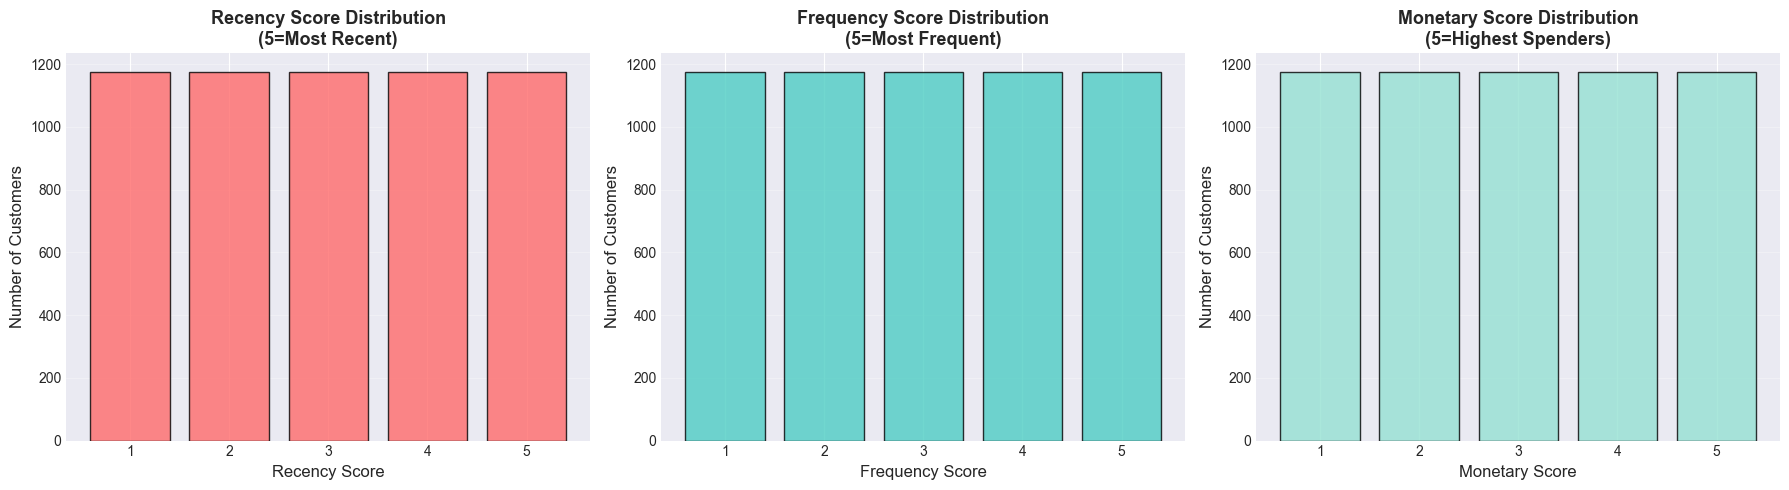

✅ Score distribution visualizations created


In [16]:
# Visualize score distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# R Score
r_dist = rfm['R_Score'].value_counts().sort_index()
axes[0].bar(r_dist.index, r_dist.values, color='#FF6B6B', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Recency Score', fontsize=12)
axes[0].set_ylabel('Number of Customers', fontsize=12)
axes[0].set_title('Recency Score Distribution\n(5=Most Recent)', fontsize=13, fontweight='bold')
axes[0].set_xticks([1, 2, 3, 4, 5])
axes[0].grid(axis='y', alpha=0.3)

# F Score
f_dist = rfm['F_Score'].value_counts().sort_index()
axes[1].bar(f_dist.index, f_dist.values, color='#4ECDC4', alpha=0.8, edgecolor='black')
axes[1].set_xlabel('Frequency Score', fontsize=12)
axes[1].set_ylabel('Number of Customers', fontsize=12)
axes[1].set_title('Frequency Score Distribution\n(5=Most Frequent)', fontsize=13, fontweight='bold')
axes[1].set_xticks([1, 2, 3, 4, 5])
axes[1].grid(axis='y', alpha=0.3)

# M Score
m_dist = rfm['M_Score'].value_counts().sort_index()
axes[2].bar(m_dist.index, m_dist.values, color='#95E1D3', alpha=0.8, edgecolor='black')
axes[2].set_xlabel('Monetary Score', fontsize=12)
axes[2].set_ylabel('Number of Customers', fontsize=12)
axes[2].set_title('Monetary Score Distribution\n(5=Highest Spenders)', fontsize=13, fontweight='bold')
axes[2].set_xticks([1, 2, 3, 4, 5])
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(path_figures + 'rfm_score_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Score distribution visualizations created")

---
## 4. Define RFM Segments

Based on RFM scores, we'll create **business-meaningful segments** with clear marketing strategies.

In [17]:
# Define customer segments based on RFM scores
def assign_rfm_segment(row):
    """
    Assign customer to RFM segment based on business logic
    
    Segment Definitions:
    - Champions: R=5, F=5, M=5 (Best customers)
    - Loyal Customers: R=4-5, F=4-5, M=3-5
    - Potential Loyalists: R=3-5, F=1-3, M=1-3
    - Recent Customers: R=4-5, F=1, M=1
    - Promising: R=3-4, F=1, M=1
    - Customers Needing Attention: R=3, F=2-3, M=2-3
    - About To Sleep: R=2-3, F=2-3, M=2-3
    - At Risk: R=1-2, F=2-5, M=2-5
    - Can't Lose Them: R=1-2, F=4-5, M=4-5
    - Hibernating: R=1-2, F=1-2, M=1-2
    - Lost: R=1, F=1, M=1
    """
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    
    # Champions - Best customers
    if r >= 5 and f >= 5 and m >= 5:
        return 'Champions'
    
    # Loyal Customers - High value regulars
    elif r >= 4 and f >= 4 and m >= 3:
        return 'Loyal Customers'
    
    # Potential Loyalists - Recent buyers with growth potential
    elif r >= 3 and f <= 3 and m <= 3:
        return 'Potential Loyalists'
    
    # Recent Customers - New customers
    elif r >= 4 and f <= 1:
        return 'Recent Customers'
    
    # Promising - Engaged but low spend
    elif r >= 3 and f <= 1:
        return 'Promising'
    
    # Customers Needing Attention - Declining engagement
    elif r == 3 and f >= 2 and f <= 3:
        return 'Need Attention'
    
    # About To Sleep - Showing signs of churn
    elif r >= 2 and r <= 3 and f >= 2 and f <= 3:
        return 'About To Sleep'
    
    # Can't Lose Them - High value customers at risk
    elif r <= 2 and f >= 4 and m >= 4:
        return "Can't Lose Them"
    
    # At Risk - Valuable customers who haven't purchased recently
    elif r <= 2 and f >= 2 and m >= 2:
        return 'At Risk'
    
    # Hibernating - Long time since purchase, low engagement
    elif r <= 2 and f <= 2 and m <= 2:
        return 'Hibernating'
    
    # Lost - Lowest engagement
    else:
        return 'Lost'

# Apply segmentation
rfm['Segment'] = rfm.apply(assign_rfm_segment, axis=1)

print("✅ Customer segments assigned")
print("\n📊 SEGMENT DISTRIBUTION")
print("="*70)
segment_counts = rfm['Segment'].value_counts().sort_values(ascending=False)
segment_pct = (segment_counts / len(rfm) * 100).round(2)

segment_summary = pd.DataFrame({
    'Count': segment_counts,
    'Percentage': segment_pct
})
print(segment_summary)

✅ Customer segments assigned

📊 SEGMENT DISTRIBUTION
                     Count  Percentage
Segment                               
Potential Loyalists   1280       21.78
Loyal Customers        979       16.66
Hibernating            901       15.33
Lost                   797       13.56
About To Sleep         606       10.31
At Risk                502        8.54
Champions              471        8.01
Can't Lose Them        227        3.86
Need Attention         104        1.77
Promising                9        0.15
Recent Customers         2        0.03


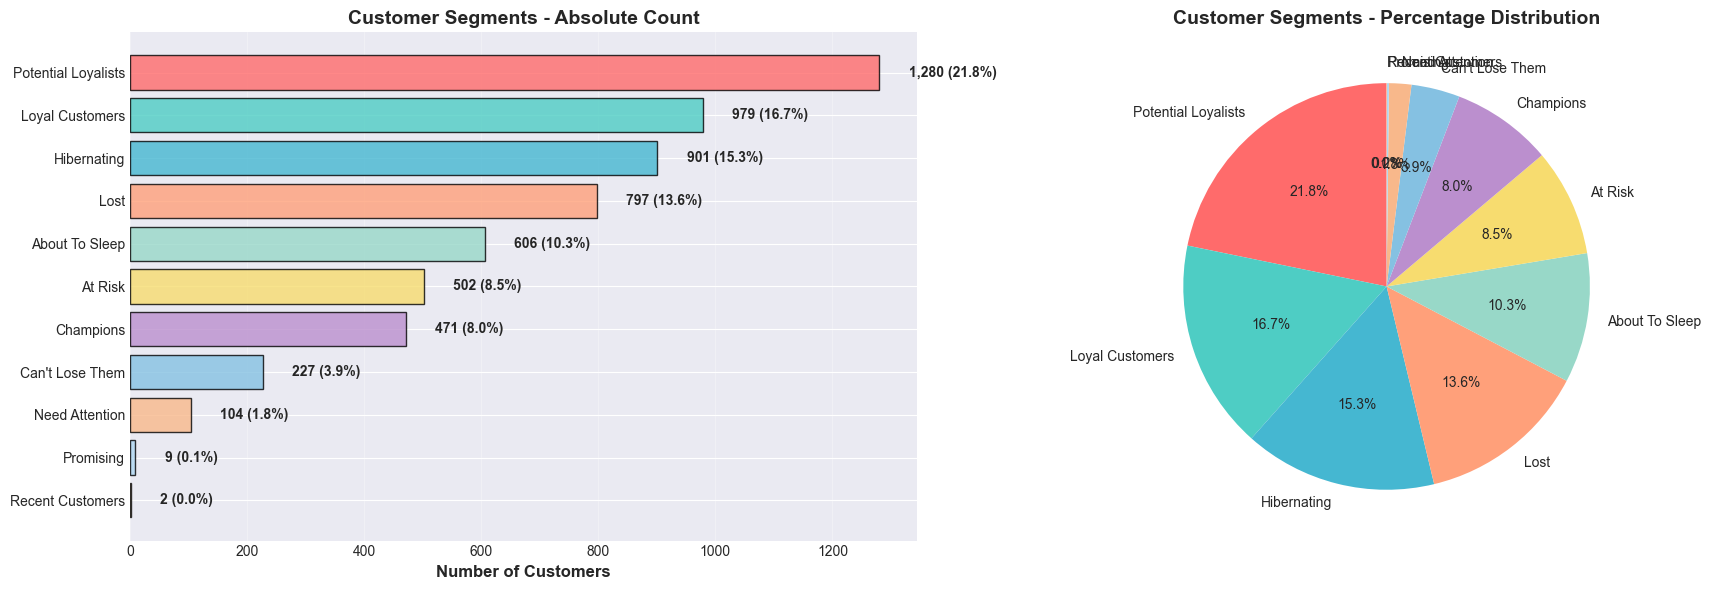

In [18]:
# Visualize segment distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', 
          '#F7DC6F', '#BB8FCE', '#85C1E2', '#F8B88B', '#AED6F1', '#FAD7A0']

axes[0].barh(range(len(segment_counts)), segment_counts.values, 
             color=colors[:len(segment_counts)], alpha=0.8, edgecolor='black')
axes[0].set_yticks(range(len(segment_counts)))
axes[0].set_yticklabels(segment_counts.index)
axes[0].set_xlabel('Number of Customers', fontsize=12, fontweight='bold')
axes[0].set_title('Customer Segments - Absolute Count', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Add count labels
for i, (count, pct) in enumerate(zip(segment_counts.values, segment_pct.values)):
    axes[0].text(count + 50, i, f'{count:,} ({pct:.1f}%)', 
                va='center', fontsize=10, fontweight='bold')

# Pie chart
axes[1].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%',
           colors=colors[:len(segment_counts)], startangle=90, textprops={'fontsize': 10})
axes[1].set_title('Customer Segments - Percentage Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(path_figures + 'segment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 5. Segment Profiling & Business Metrics

In [19]:
# Create comprehensive segment profiles
segment_profiles = rfm.groupby('Segment').agg({
    'CustomerID': 'count',
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'sum'],
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).round(2)

# Flatten column names
segment_profiles.columns = ['_'.join(col).strip('_') for col in segment_profiles.columns]
segment_profiles.columns = ['Customer_Count', 'Avg_Recency', 'Median_Recency', 
                            'Avg_Frequency', 'Median_Frequency',
                            'Avg_Monetary', 'Median_Monetary', 'Total_Revenue',
                            'Avg_R_Score', 'Avg_F_Score', 'Avg_M_Score']

# Add percentage columns
segment_profiles['Customer_Pct'] = (segment_profiles['Customer_Count'] / segment_profiles['Customer_Count'].sum() * 100).round(2)
segment_profiles['Revenue_Pct'] = (segment_profiles['Total_Revenue'] / segment_profiles['Total_Revenue'].sum() * 100).round(2)

# Sort by total revenue
segment_profiles = segment_profiles.sort_values('Total_Revenue', ascending=False)

print("💼 SEGMENT PROFILES - COMPLETE BUSINESS METRICS")
print("="*70)
print(segment_profiles.to_string())

# Export segment profiles
segment_profiles.to_csv(path_reports + 'rfm_segment_profiles.csv')
print("\n✅ Segment profiles exported to: rfm_segment_profiles.csv")

💼 SEGMENT PROFILES - COMPLETE BUSINESS METRICS
                     Customer_Count  Avg_Recency  Median_Recency  Avg_Frequency  Median_Frequency  Avg_Monetary  Median_Monetary  Total_Revenue  Avg_R_Score  Avg_F_Score  Avg_M_Score  Customer_Pct  Revenue_Pct
Segment                                                                                                                                                                                                          
Champions                       471         7.78             7.0          28.62              20.0      17692.41          7713.57     8333125.12         5.00         5.00         5.00          8.01        46.96
Loyal Customers                 979        26.04            24.0           9.72               8.0       3990.92          2430.53     3907110.54         4.36         4.44         4.21         16.66        22.02
Lost                            797       139.46            90.0           6.53               5.0       2976.91  

In [20]:
# Key insights from segment profiles
print("\n🎯 KEY SEGMENT INSIGHTS")
print("="*70)

# Most valuable segment
top_revenue_segment = segment_profiles.index[0]
top_revenue = segment_profiles.iloc[0]['Total_Revenue']
top_revenue_pct = segment_profiles.iloc[0]['Revenue_Pct']
print(f"\n💎 Most Valuable Segment: {top_revenue_segment}")
print(f"   Revenue: £{top_revenue:,.2f} ({top_revenue_pct:.1f}% of total)")
print(f"   Customers: {segment_profiles.iloc[0]['Customer_Count']:,.0f} ({segment_profiles.iloc[0]['Customer_Pct']:.1f}%)")
print(f"   Avg Spend: £{segment_profiles.iloc[0]['Avg_Monetary']:,.2f}")

# Largest segment by customer count
largest_segment = segment_profiles['Customer_Count'].idxmax()
print(f"\n👥 Largest Segment by Customer Count: {largest_segment}")
print(f"   Customers: {segment_profiles.loc[largest_segment, 'Customer_Count']:,.0f} ({segment_profiles.loc[largest_segment, 'Customer_Pct']:.1f}%)")
print(f"   Revenue: £{segment_profiles.loc[largest_segment, 'Total_Revenue']:,.2f}")

# At-risk high value customers
at_risk_segments = ['At Risk', "Can't Lose Them", 'Hibernating']
at_risk_data = segment_profiles[segment_profiles.index.isin(at_risk_segments)]
if len(at_risk_data) > 0:
    at_risk_customers = at_risk_data['Customer_Count'].sum()
    at_risk_revenue = at_risk_data['Total_Revenue'].sum()
    print(f"\n⚠️  At-Risk Customers (Need Immediate Attention):")
    print(f"   Total at-risk customers: {at_risk_customers:,.0f}")
    print(f"   Revenue at risk: £{at_risk_revenue:,.2f}")
    print(f"   → Priority: Win-back campaigns required!")

# Growth opportunity
growth_segments = ['Potential Loyalists', 'Promising', 'Recent Customers']
growth_data = segment_profiles[segment_profiles.index.isin(growth_segments)]
if len(growth_data) > 0:
    growth_customers = growth_data['Customer_Count'].sum()
    growth_revenue = growth_data['Total_Revenue'].sum()
    print(f"\n🚀 Growth Opportunity Segments:")
    print(f"   Customers with growth potential: {growth_customers:,.0f}")
    print(f"   Current revenue: £{growth_revenue:,.2f}")
    print(f"   → Strategy: Nurture campaigns to increase frequency & spend")


🎯 KEY SEGMENT INSIGHTS

💎 Most Valuable Segment: Champions
   Revenue: £8,333,125.12 (47.0% of total)
   Customers: 471 (8.0%)
   Avg Spend: £17,692.41

👥 Largest Segment by Customer Count: Potential Loyalists
   Customers: 1,280 (21.8%)
   Revenue: £673,380.64

⚠️  At-Risk Customers (Need Immediate Attention):
   Total at-risk customers: 1,630
   Revenue at risk: £1,694,346.35
   → Priority: Win-back campaigns required!

🚀 Growth Opportunity Segments:
   Customers with growth potential: 1,291
   Current revenue: £700,980.40
   → Strategy: Nurture campaigns to increase frequency & spend


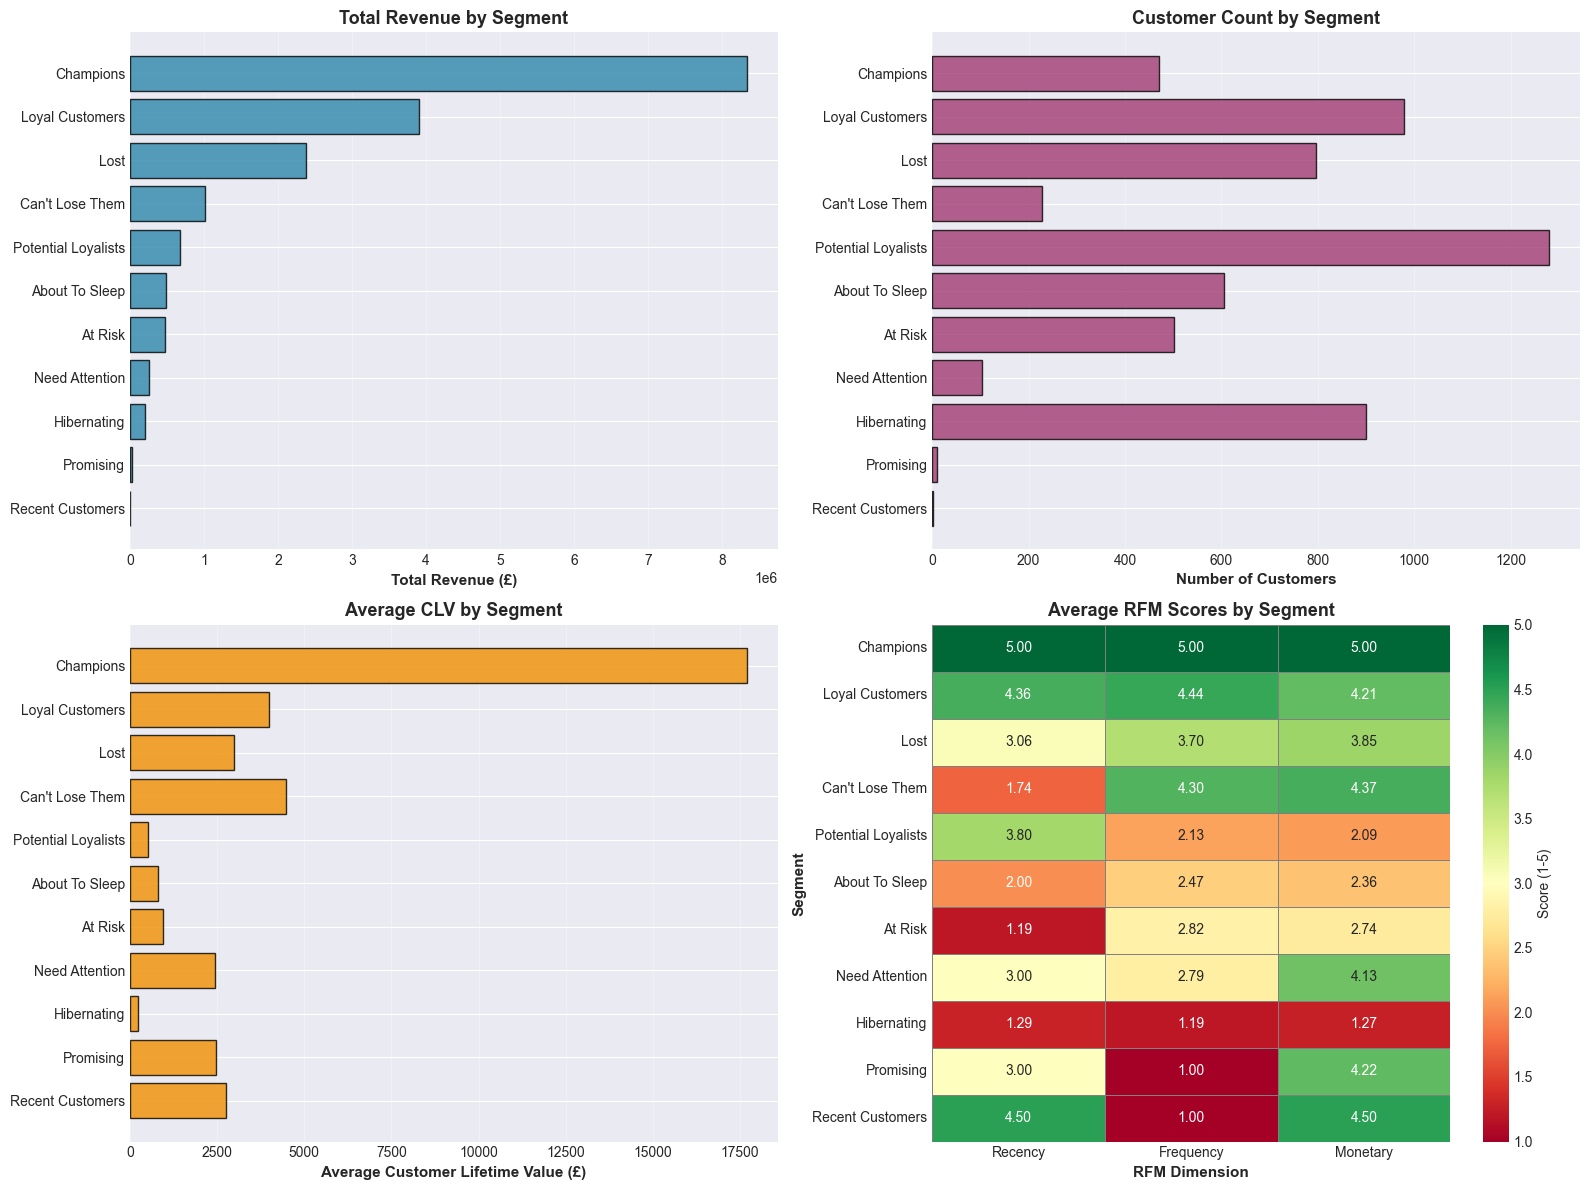

✅ Segment comparison visualizations created


In [21]:
# Visualize segment comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Revenue by Segment
segments = segment_profiles.index
revenues = segment_profiles['Total_Revenue']
axes[0, 0].barh(range(len(segments)), revenues, color='#2E86AB', alpha=0.8, edgecolor='black')
axes[0, 0].set_yticks(range(len(segments)))
axes[0, 0].set_yticklabels(segments)
axes[0, 0].set_xlabel('Total Revenue (£)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Total Revenue by Segment', fontsize=13, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)
axes[0, 0].invert_yaxis()

# 2. Customer Count by Segment
counts = segment_profiles['Customer_Count']
axes[0, 1].barh(range(len(segments)), counts, color='#A23B72', alpha=0.8, edgecolor='black')
axes[0, 1].set_yticks(range(len(segments)))
axes[0, 1].set_yticklabels(segments)
axes[0, 1].set_xlabel('Number of Customers', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Customer Count by Segment', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].invert_yaxis()

# 3. Average Monetary Value
avg_monetary = segment_profiles['Avg_Monetary']
axes[1, 0].barh(range(len(segments)), avg_monetary, color='#F18F01', alpha=0.8, edgecolor='black')
axes[1, 0].set_yticks(range(len(segments)))
axes[1, 0].set_yticklabels(segments)
axes[1, 0].set_xlabel('Average Customer Lifetime Value (£)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Average CLV by Segment', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)
axes[1, 0].invert_yaxis()

# 4. RFM Score Heatmap by Segment
rfm_scores = segment_profiles[['Avg_R_Score', 'Avg_F_Score', 'Avg_M_Score']]
sns.heatmap(rfm_scores, annot=True, fmt='.2f', cmap='RdYlGn', 
            cbar_kws={'label': 'Score (1-5)'}, ax=axes[1, 1],
            linewidths=0.5, linecolor='gray')
axes[1, 1].set_title('Average RFM Scores by Segment', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('RFM Dimension', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Segment', fontsize=11, fontweight='bold')
axes[1, 1].set_xticklabels(['Recency', 'Frequency', 'Monetary'])

plt.tight_layout()
plt.savefig(path_figures + 'segment_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Segment comparison visualizations created")

---
## 6. Marketing Recommendations per Segment

In [22]:
# Define marketing strategies for each segment
marketing_strategies = {
    'Champions': {
        'Description': 'Best customers - recent buyers, frequent purchasers, high spenders',
        'Strategy': 'Reward & retain through VIP programs',
        'Tactics': [
            'Early access to new products',
            'Exclusive loyalty rewards',
            'Personalized thank you messages',
            'Request reviews & referrals',
            'Premium customer service'
        ],
        'Channel': 'Email, SMS, Direct mail',
        'Priority': '🔴 CRITICAL - Retain at all costs'
    },
    
    'Loyal Customers': {
        'Description': 'Regular high-value customers with strong engagement',
        'Strategy': 'Nurture loyalty & increase purchase frequency',
        'Tactics': [
            'Upsell premium products',
            'Loyalty point bonuses',
            'Bundle recommendations',
            'Birthday/anniversary offers',
            'Cross-sell complementary items'
        ],
        'Channel': 'Email, App notifications',
        'Priority': '🔴 HIGH - Key revenue drivers'
    },
    
    'Potential Loyalists': {
        'Description': 'Recent buyers with potential to become loyal customers',
        'Strategy': 'Engage & convert to regular customers',
        'Tactics': [
            'Onboarding email series',
            'Product education content',
            'Limited-time repeat purchase discounts',
            'Personalized recommendations',
            'Engagement surveys'
        ],
        'Channel': 'Email, Retargeting ads',
        'Priority': '🟡 MEDIUM - Growth opportunity'
    },
    
    'Recent Customers': {
        'Description': 'Brand new customers (first purchase)',
        'Strategy': 'Build relationship & encourage second purchase',
        'Tactics': [
            'Welcome series (3-5 emails)',
            'Second purchase incentive (15% off)',
            'Product usage tips',
            'Customer success stories',
            'Ask for feedback'
        ],
        'Channel': 'Email automation',
        'Priority': '🟡 MEDIUM - Critical conversion window'
    },
    
    'Promising': {
        'Description': 'Engaged recently but low spend',
        'Strategy': 'Increase average order value',
        'Tactics': [
            'Free shipping thresholds',
            'Volume discounts',
            'Bundle deals',
            'Show higher-value alternatives',
            'Limited-time premium offers'
        ],
        'Channel': 'Email, Website personalization',
        'Priority': '🟡 MEDIUM - Revenue growth potential'
    },
    
    'Need Attention': {
        'Description': 'Declining recency, moderate engagement',
        'Strategy': 'Re-engage before they slip away',
        'Tactics': [
            '"We miss you" campaigns',
            'Personalized product recommendations',
            'Special comeback offers',
            'Survey to understand barriers',
            'Reminder of benefits/values'
        ],
        'Channel': 'Email, Retargeting',
        'Priority': '🟠 MODERATE - Prevent churn'
    },
    
    'About To Sleep': {
        'Description': 'Declining engagement, at risk of churning',
        'Strategy': 'Urgent re-activation required',
        'Tactics': [
            'Aggressive win-back discounts (20-30%)',
            'Multi-channel approach',
            'Share new product launches',
            'Personalized phone outreach (high-value)',
            'Reactivation contest/giveaway'
        ],
        'Channel': 'Email, SMS, Phone (high-value)',
        'Priority': '🟠 URGENT - Last chance to retain'
    },
    
    "Can't Lose Them": {
        'Description': 'High-value customers who stopped buying',
        'Strategy': 'Premium win-back - highest priority',
        'Tactics': [
            'Personal outreach from account manager',
            'Exclusive VIP win-back offer',
            'Understand reason for departure (survey/call)',
            'Offer to resolve any issues',
            'Premium gift/incentive'
        ],
        'Channel': 'Phone, Email, Direct mail',
        'Priority': '🔴 CRITICAL - Immediate intervention required'
    },
    
    'At Risk': {
        'Description': 'Valuable customers with declining activity',
        'Strategy': 'Prevent churn through targeted offers',
        'Tactics': [
            'Win-back campaign series',
            'Show relevant new products',
            'Limited-time special offers',
            'Remind of past positive experiences',
            'Feedback request to improve'
        ],
        'Channel': 'Email, Retargeting, SMS',
        'Priority': '🟠 HIGH - Revenue preservation'
    },
    
    'Hibernating': {
        'Description': 'Long inactive, low historical value',
        'Strategy': 'Low-cost reactivation attempts',
        'Tactics': [
            'Seasonal campaigns only',
            'Minimal email frequency',
            'Deep discounts (last attempt)',
            'Brand refresh messaging',
            'Consider list cleanup'
        ],
        'Channel': 'Email (low frequency)',
        'Priority': '🟢 LOW - Minimal investment'
    },
    
    'Lost': {
        'Description': 'No activity, lowest engagement',
        'Strategy': 'Minimal engagement or remove from active lists',
        'Tactics': [
            'Final "last chance" email',
            'Preference center (reduce frequency)',
            'Unsubscribe option',
            'Remove from active campaigns',
            'Focus resources on viable segments'
        ],
        'Channel': 'Email (very low frequency)',
        'Priority': '🟢 MINIMAL - List hygiene focus'
    }
}

print("\n📋 MARKETING PLAYBOOK - SEGMENT STRATEGIES")
print("="*70)

for segment in segment_profiles.index:
    if segment in marketing_strategies:
        strategy = marketing_strategies[segment]
        customers = segment_profiles.loc[segment, 'Customer_Count']
        revenue = segment_profiles.loc[segment, 'Total_Revenue']
        
        print(f"\n{'='*70}")
        print(f"🎯 SEGMENT: {segment}")
        print(f"{'='*70}")
        print(f"📊 Size: {customers:,.0f} customers (£{revenue:,.2f} revenue)")
        print(f"📝 {strategy['Description']}")
        print(f"\n{strategy['Priority']}")
        print(f"\n💡 STRATEGY: {strategy['Strategy']}")
        print(f"\n📱 CHANNEL: {strategy['Channel']}")
        print(f"\n✅ RECOMMENDED TACTICS:")
        for i, tactic in enumerate(strategy['Tactics'], 1):
            print(f"   {i}. {tactic}")

print(f"\n{'='*70}")
print("✅ Marketing playbook generated for all segments")


📋 MARKETING PLAYBOOK - SEGMENT STRATEGIES

🎯 SEGMENT: Champions
📊 Size: 471 customers (£8,333,125.12 revenue)
📝 Best customers - recent buyers, frequent purchasers, high spenders

🔴 CRITICAL - Retain at all costs

💡 STRATEGY: Reward & retain through VIP programs

📱 CHANNEL: Email, SMS, Direct mail

✅ RECOMMENDED TACTICS:
   1. Early access to new products
   2. Exclusive loyalty rewards
   3. Personalized thank you messages
   4. Request reviews & referrals
   5. Premium customer service

🎯 SEGMENT: Loyal Customers
📊 Size: 979 customers (£3,907,110.54 revenue)
📝 Regular high-value customers with strong engagement

🔴 HIGH - Key revenue drivers

💡 STRATEGY: Nurture loyalty & increase purchase frequency

📱 CHANNEL: Email, App notifications

✅ RECOMMENDED TACTICS:
   1. Upsell premium products
   2. Loyalty point bonuses
   3. Bundle recommendations
   4. Birthday/anniversary offers
   5. Cross-sell complementary items

🎯 SEGMENT: Lost
📊 Size: 797 customers (£2,372,600.78 revenue)
📝 No ac

---
## 7. Executive Dashboard Data Export

In [ ]:
# Save complete RFM dataset with segments
rfm.to_csv(path_processed + 'rfm_customer_scores.csv', index=False)
print("✅ Complete RFM dataset saved to: rfm_customer_scores.csv")

# Create summary for executive dashboard
exec_summary = {
    'total_customers': int(len(rfm)),
    'total_revenue': float(rfm['Monetary'].sum()),
    'avg_customer_value': float(rfm['Monetary'].mean()),
    'median_customer_value': float(rfm['Monetary'].median()),
    'avg_recency_days': float(rfm['Recency'].mean()),
    'avg_purchase_frequency': float(rfm['Frequency'].mean()),
    'segments': segment_profiles.to_dict('index')
}

import json
with open(path_reports + 'rfm_executive_summary.json', 'w') as f:
    json.dump(exec_summary, f, indent=2)

print("✅ Executive summary saved to: rfm_executive_summary.json")

# Create actionable customer lists for campaigns
print("\n📋 CREATING ACTIONABLE CUSTOMER LISTS FOR CAMPAIGNS")
print("="*70)

# High-priority segments for immediate action
champions = rfm[rfm['Segment'] == 'Champions'][['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score']]
champions.to_csv(path_campaigns + 'segment_champions.csv', index=False)
print(f"✅ Champions list: {len(champions):,} customers → segment_champions.csv")

cant_lose = rfm[rfm['Segment'] == "Can't Lose Them"][['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score']]
if len(cant_lose) > 0:
    cant_lose.to_csv(path_campaigns + 'segment_cant_lose.csv', index=False)
    print(f"⚠️  Can't Lose Them: {len(cant_lose):,} customers → segment_cant_lose.csv")

at_risk = rfm[rfm['Segment'] == 'At Risk'][['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score']]
if len(at_risk) > 0:
    at_risk.to_csv(path_campaigns + 'segment_at_risk.csv', index=False)
    print(f"⚠️  At Risk: {len(at_risk):,} customers → segment_at_risk.csv")

potential_loyalists = rfm[rfm['Segment'] == 'Potential Loyalists'][['CustomerID', 'Recency', 'Frequency', 'Monetary', 'RFM_Score']]
if len(potential_loyalists) > 0:
    potential_loyalists.to_csv(path_campaigns + 'segment_potential_loyalists.csv', index=False)
    print(f"🚀 Potential Loyalists: {len(potential_loyalists):,} customers → segment_potential_loyalists.csv")

print("\n✅ All customer segment lists exported for campaign execution")

✅ Complete RFM dataset saved to: rfm_customer_scores.csv
✅ Executive summary saved to: rfm_executive_summary.json

📋 CREATING ACTIONABLE CUSTOMER LISTS FOR CAMPAIGNS
✅ Champions list: 471 customers → segment_champions.csv
⚠️  Can't Lose Them: 227 customers → segment_cant_lose.csv
⚠️  At Risk: 502 customers → segment_at_risk.csv
🚀 Potential Loyalists: 1,280 customers → segment_potential_loyalists.csv

✅ All customer segment lists exported for campaign execution


---
## 8. RFM Analysis Summary & Next Steps

In [24]:
print("\n" + "="*70)
print("📊 RFM ANALYSIS - PHASE 2 COMPLETE")
print("="*70)

print("\n✅ DELIVERABLES COMPLETED:")
print("   1. ✅ RFM scores calculated for all customers (1-5 scale)")
print("   2. ✅ Customer segments defined with business logic")
print(f"   3. ✅ {len(segment_profiles)} actionable segments created")
print("   4. ✅ Segment profiles with complete business metrics")
print("   5. ✅ Marketing playbook with strategies per segment")
print("   6. ✅ Executive visualizations & dashboards")
print("   7. ✅ Campaign-ready customer lists exported")

print("\n📁 FILES GENERATED:")
print("   • rfm_customer_scores.csv - Complete RFM dataset")
print("   • rfm_segment_profiles.csv - Segment business metrics")
print("   • rfm_executive_summary.json - Dashboard data")
print("   • segment_champions.csv - VIP customer list")
print("   • segment_cant_lose.csv - Critical win-back list")
print("   • segment_at_risk.csv - Churn prevention list")
print("   • segment_potential_loyalists.csv - Growth opportunity list")

print("\n📊 VISUALIZATIONS CREATED:")
print("   • rfm_score_distributions.png")
print("   • segment_distribution.png")
print("   • segment_comparison.png")

print("\n🎯 TOP 3 IMMEDIATE ACTIONS:")
print("   1. 🔴 URGENT: Launch win-back campaign for 'Can't Lose Them' segment")
print("   2. 🔴 HIGH: Reward Champions with exclusive VIP benefits")
print("   3. 🟡 MEDIUM: Nurture 'Potential Loyalists' with engagement series")

print("\n🚀 PHASE 3 PREVIEW: Advanced Feature Engineering")
print("   → Build behavioral, temporal, and monetary features")
print("   → Prepare for advanced clustering algorithms")
print("   → Create predictive features (churn risk, CLV forecast)")

print("\n" + "="*70)
print("✅ PHASE 2 COMPLETE - Ready for Phase 3: Feature Engineering")
print("="*70)


📊 RFM ANALYSIS - PHASE 2 COMPLETE

✅ DELIVERABLES COMPLETED:
   1. ✅ RFM scores calculated for all customers (1-5 scale)
   2. ✅ Customer segments defined with business logic
   3. ✅ 11 actionable segments created
   4. ✅ Segment profiles with complete business metrics
   5. ✅ Marketing playbook with strategies per segment
   6. ✅ Executive visualizations & dashboards
   7. ✅ Campaign-ready customer lists exported

📁 FILES GENERATED:
   • rfm_customer_scores.csv - Complete RFM dataset
   • rfm_segment_profiles.csv - Segment business metrics
   • rfm_executive_summary.json - Dashboard data
   • segment_champions.csv - VIP customer list
   • segment_cant_lose.csv - Critical win-back list
   • segment_at_risk.csv - Churn prevention list
   • segment_potential_loyalists.csv - Growth opportunity list

📊 VISUALIZATIONS CREATED:
   • rfm_score_distributions.png
   • segment_distribution.png
   • segment_comparison.png

🎯 TOP 3 IMMEDIATE ACTIONS:
   1. 🔴 URGENT: Launch win-back campaign for '